In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
DATA_ROOT = os.path.expanduser("../data")
TILE_DIR  = os.path.join(DATA_ROOT, "rubin_tiles_ecdfs")

files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
print(len(files), files[:3])

f = np.load(files[0])
print(f.files)
img  = f["img"]  
bands = ["u", "g", "r", "i","z","y"]

fig, axs = plt.subplots(1, img.shape[0], figsize=(12,4))
for i, ax in enumerate(axs):
    lo, hi = np.percentile(img[i], (1,99))
    ax.imshow(img[i], origin="lower", vmin=lo, vmax=hi)
    ax.set_title(bands[i])
    ax.axis("off")
plt.show()


In [ ]:

import os, glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

TILE_DIR = os.path.expanduser("../data/rubin_tiles_ecdfs_gr_i")
files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
len(files), files[:3]

def wcs_from_npz_wcs_hdr(wcs_hdr):
    """
    wcs_hdr is stored as a dict in the NPZ. Turn it into an astropy.wcs.WCS.
    """
    # np.load gives object arrays sometimes; ensure plain dict
    if isinstance(wcs_hdr, np.ndarray) and wcs_hdr.dtype == object:
        wcs_hdr = wcs_hdr.item()
    return WCS(wcs_hdr)

def tile_footprint_radec(npz_path):
    z = np.load(npz_path, allow_pickle=True)
    img = z["img"]
    H, W = img.shape[-2], img.shape[-1]

    w = wcs_from_npz_wcs_hdr(z["wcs_hdr"])

    # pixel corners (0-indexed pixel coordinates in the cutout)
    # corners in order: (0,0) (W,0) (W,H) (0,H) and close polygon
    px = np.array([0, W, W, 0, 0], dtype=float)
    py = np.array([0, 0, H, H, 0], dtype=float)

    ra, dec = w.wcs_pix2world(px, py, 0)  # origin=0 for 0-indexed
    return ra, dec

    plt.figure(figsize=(8,8))

# If many tiles, plot a subset first
use = files[:200]  # adjust

for fp in use:
    ra, dec = tile_footprint_radec(fp)

    # RA wrap handling: for small fields it's usually fine, but this keeps it stable
    ra = np.unwrap(np.deg2rad(ra))
    ra = np.rad2deg(ra)

    plt.plot(ra, dec, lw=0.6, alpha=0.5)

plt.gca().invert_xaxis()  # standard sky convention: RA increases to the left
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Tile footprints from NPZ WCS")
plt.show()



In [ ]:
class RubinTileDataset(Dataset):
    def __init__(self, tile_dir):
        self.files = sorted(glob.glob(os.path.join(tile_dir, "*.npz")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = np.load(self.files[idx])
        img = torch.from_numpy(f["img"]).float()   # [B,H,W]
        var = torch.from_numpy(f["var"]).float()
        msk = torch.from_numpy(f["mask"]).long()
        return img, var, msk

ds = RubinTileDataset(TILE_DIR)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

img, var, msk = next(iter(dl))
img.shape, var.shape, msk.shape


In [ ]:
class TinyConv(nn.Module):
    def __init__(self, in_ch=3, out_ch=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_ch, 3, padding=1),
        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyConv().to(device)

img = img.to(device)
var = var.to(device)

out = model(img)
loss = (out**2).mean()   # dummy loss

loss.backward()
loss.item()



In [9]:
import os, glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

bands_rubin  = ["u","g","r","i","z","y"]
bands_euclid_vis  = ["VIS"]
bands_euclid_nisp = ["Y","J","H"]

class ECDFSCrossSurveyDataset(Dataset):
    def __init__(self, rubin_dir, euclid_vis_dir, euclid_nisp_dir):
        self.rubin_dir = rubin_dir
        self.euclid_vis_dir = euclid_vis_dir
        self.euclid_nisp_dir = euclid_nisp_dir

        self.rubin_files = sorted(glob.glob(os.path.join(rubin_dir, "*.npz")))
        if not self.rubin_files:
            raise ValueError(f"No Rubin tiles found in {rubin_dir}")

        # index by tile_id (basename)
        self.tile_ids = [os.path.splitext(os.path.basename(p))[0] for p in self.rubin_files]

        # ✅ FIX: build tile_id -> idx mapping
        self.id_to_idx = {tid: i for i, tid in enumerate(self.tile_ids)}

    def __len__(self):
        return len(self.tile_ids)

    def get_by_tile_id(self, tile_id):
        if tile_id not in self.id_to_idx:
            raise KeyError(f"tile_id {tile_id} not found in dataset")
        return self[self.id_to_idx[tile_id]]

    def __getitem__(self, idx):
        # ✅ NICE: allow ds["tile_x...."] directly
        if isinstance(idx, str):
            if idx not in self.id_to_idx:
                raise KeyError(f"tile_id {idx} not found in dataset")
            idx = self.id_to_idx[idx]

        tile_id = self.tile_ids[idx]

        # --- Rubin ---
        r = np.load(os.path.join(self.rubin_dir, f"{tile_id}.npz"), allow_pickle=True)
        rubin_img  = torch.from_numpy(r["img"]).float()   # [6,512,512]
        rubin_var  = torch.from_numpy(r["var"]).float()
        rubin_mask = torch.from_numpy(r["mask"]).int()
        ra = float(r["ra_center"]); dec = float(r["dec_center"])

        # --- Euclid VIS ---
        vpath = os.path.join(self.euclid_vis_dir, f"{tile_id}.npz")
        v = np.load(vpath, allow_pickle=True) if os.path.exists(vpath) else None
        if v is None:
            vis_img = torch.zeros((1,1,1), dtype=torch.float32)
            vis_valid = torch.zeros((1,1,1), dtype=torch.uint8)
        else:
            vis_img = torch.from_numpy(v["img"]).float()          # [1,H,W]
            vis_valid = torch.from_numpy(v["valid"]).to(torch.uint8)

        # --- Euclid NISP ---
        npath = os.path.join(self.euclid_nisp_dir, f"{tile_id}.npz")
        n = np.load(npath, allow_pickle=True) if os.path.exists(npath) else None
        if n is None:
            nisp_img = torch.zeros((3,1,1), dtype=torch.float32)
            nisp_valid = torch.zeros((3,1,1), dtype=torch.uint8)
        else:
            nisp_img = torch.from_numpy(n["img"]).float()         # [3,H,W]
            nisp_valid = torch.from_numpy(n["valid"]).to(torch.uint8)

        return {
            "tile_id": tile_id,
            "ra_center": ra,
            "dec_center": dec,
            "rubin": {
                "img": rubin_img, "var": rubin_var, "mask": rubin_mask,
                "bands": bands_rubin,
            },
            "euclid_vis": {
                "img": vis_img, "valid": vis_valid, "bands": bands_euclid_vis,
            },
            "euclid_nisp": {
                "img": nisp_img, "valid": nisp_valid, "bands": bands_euclid_nisp,
            },
        }

# --- usage ---
ds = ECDFSCrossSurveyDataset(
    rubin_dir="../data/rubin_tiles_ecdfs",
    euclid_vis_dir="../data/euclid_tiles_VIS",
    euclid_nisp_dir="../data/euclid_tiles_NISP",
)

# ✅ Get a specific tile (no DataLoader needed)
sample = ds["tile_x00000_y01280"]   # or ds.get_by_tile_id(...)
print("Tile:", sample["tile_id"])
print("Rubin:", sample["rubin"]["img"].shape)
print("Euclid VIS:", sample["euclid_vis"]["img"].shape)
print("Euclid NISP:", sample["euclid_nisp"]["img"].shape)

# If you still want DataLoader for iteration:
dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
batch = next(iter(dl))
print("First batch tile_ids:", batch["tile_id"])


Tile: tile_x00000_y01280
Rubin: torch.Size([6, 512, 512])
Euclid VIS: torch.Size([1, 554, 1024])
Euclid NISP: torch.Size([3, 554, 1024])
First batch tile_ids: ['tile_x00000_y00000']


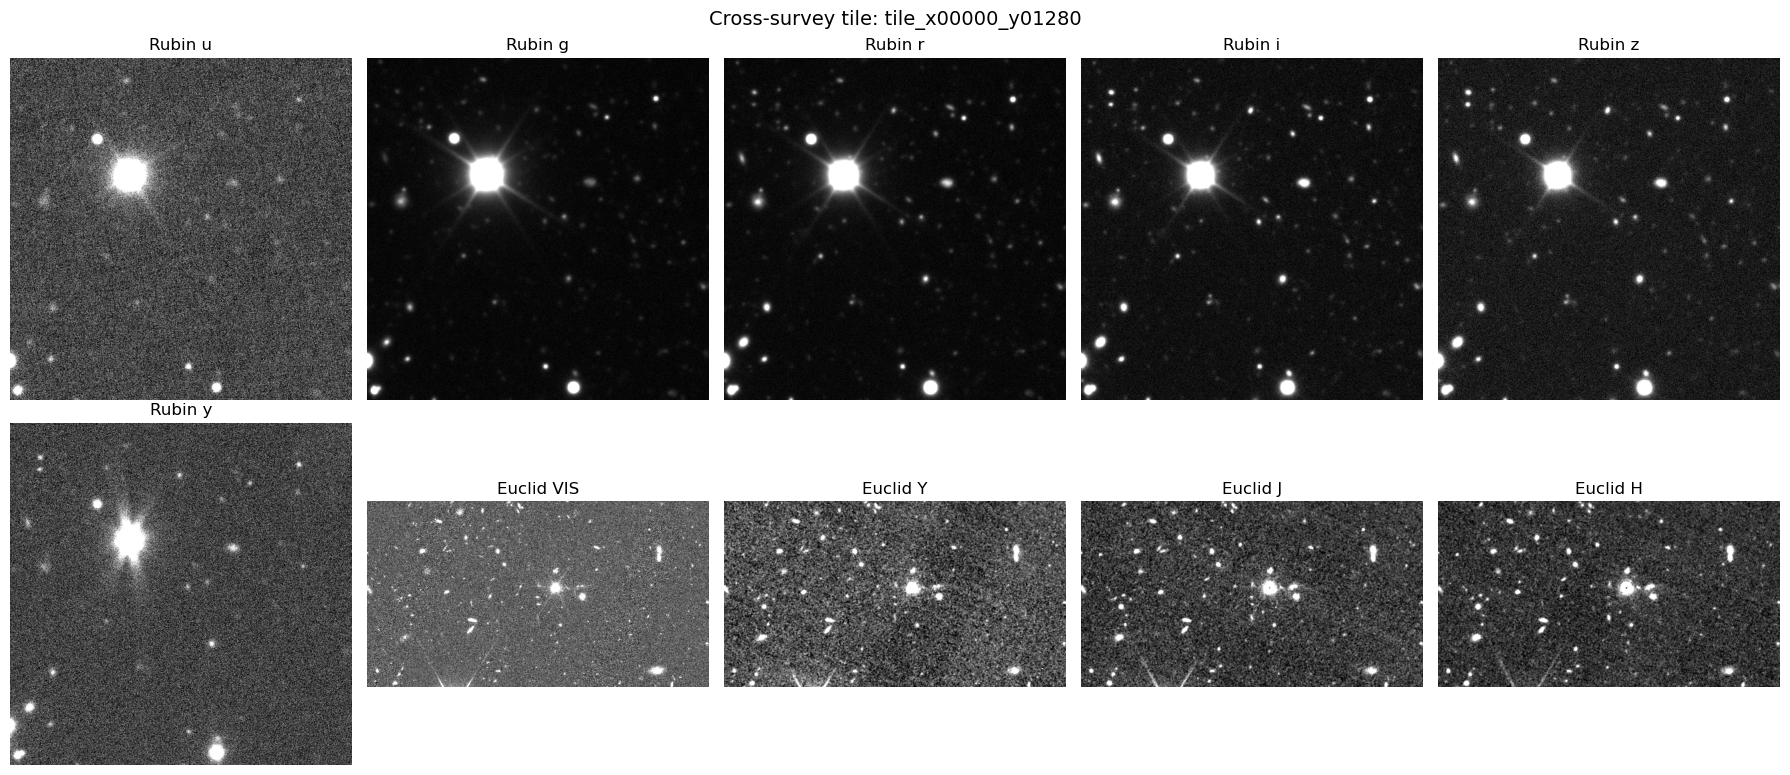

In [11]:
import matplotlib.pyplot as plt
import numpy as np

sample = ds["tile_x00000_y01280"]   # single sample, NOT batched

def stretch_p1_p99(img, p=(1,99)):
    img = np.asarray(img)
    if img.size == 0:
        return img
    lo, hi = np.nanpercentile(img, p)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(img, dtype=np.float32)
    return np.clip((img - lo) / (hi - lo), 0, 1)

# ✅ no [0] here
rubin_img = sample["rubin"]["img"].numpy()        # (6,512,512)
vis_img   = sample["euclid_vis"]["img"].numpy()   # (1,H,W)
nisp_img  = sample["euclid_nisp"]["img"].numpy()  # (3,H,W)

tile_id = sample["tile_id"]  # ✅ string

rubin_bands = sample["rubin"]["bands"]
nisp_bands  = sample["euclid_nisp"]["bands"]

# ---- plotting ----
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()
k = 0

# --- Rubin (6 panels; last spills into next row because 2x5=10) ---
for i, b in enumerate(rubin_bands):
    img = stretch_p1_p99(rubin_img[i])
    axes[k].imshow(img, origin="lower", cmap="gray")
    axes[k].set_title(f"Rubin {b}")
    axes[k].axis("off")
    k += 1

# --- Euclid VIS ---
img = stretch_p1_p99(vis_img[0])
axes[k].imshow(img, origin="lower", cmap="gray")
axes[k].set_title("Euclid VIS")
axes[k].axis("off")
k += 1

# --- Euclid NISP (Y/J/H) ---
for i, b in enumerate(nisp_bands):
    img = stretch_p1_p99(nisp_img[i])
    axes[k].imshow(img, origin="lower", cmap="gray")
    axes[k].set_title(f"Euclid {b}")
    axes[k].axis("off")
    k += 1

# turn off remaining axes
while k < len(axes):
    axes[k].axis("off")
    k += 1

plt.suptitle(f"Cross-survey tile: {tile_id}", fontsize=14)
plt.tight_layout()
plt.show()
